# Notebook 5: Normal Modes

The potential energy of a single spring is given by Hookes law

$$U(x) = \frac{1}{2} k (x-\ell)^2 $$


where $k$ is the spring constant, $x$ is springs length and $\ell$ is the springs rest length. An elastic network is just a bunch of springs connected together so the potential energy of the network is given by,


$$U(r) = \frac{1}{2} \sum_{i<i} S_{ij} (\delta r_{ij} - \ell_{ij})^2 $$

$$\delta r_{ij} = || R_i - R_j ||$$
$$R_i = (x_i,y_i)$$

where $S_{ij}$ is our spring matrix that stores the spring constant between nodes $i$ and $j$, $\delta r_{ij}$ is the distance between nodes $i$ and $j$ and $\ell_{ij}$ is the rest length. Note that this energy is rugged with many minima.

If where are only interested in a local features of $U(r)$ around point $r_0$ then we can use a Taylor expansion.

$$U(r_0 + \Delta r) \approx U(r) + \sum_{i} \frac{\partial U}{\partial r_i} \Delta r_i + \sum_{ij} \frac{\partial^2 U}{\partial r_i \partial r_j} \Delta r_i \Delta r_j$$

or if you prefer matrix notation,

$$U(r_0 + \Delta r) \approx U(r) + \nabla U \Delta r + \Delta r^T H \Delta r$$

Where $H_{ij} = \frac{\partial^2 U}{\partial r_i  \partial r_j} $

$H$ is call the Hessian Matrix, a matrix of all second order partial derivatives. If we chose the restlengths such that in conformation $r_0$ none of the springs are stress, then expantion reduces to  

$$U(\Delta r) \approx \Delta r^T H \Delta r$$

Thus our approxmate energy lanscape of our elastic network is a quadratic basin. 

How can we understand the motions of the networks? which motions $\Delta r$ require large force to actuate and require little force? To do this we diagonaize $H$

$$H = U \Lambda U^T$$

The eigenvectors, the columns of $U$, are the "normal modes" of the elastic network and the eigenvalues, values on the diagonal of $\Lambda$, are the stiffnesses of each normal mode. 

## Computing the Hessian Matrix

Now we have to compute the Hessian matrix. Since it can be a tedious task we will go through it slowly. There are a couple things to keep in minds,

1. Our structure vector has the form $r = (x_1, y_1, x_2, y_2, \dots , x_n, y_n)$. Our Hessian must have a compatible layout,



$$
H = \begin{matrix}
U_{x_1 x_1} & U_{x_1 y_1} & U_{x_1 x_2} & U_{x_1 y_2}  & \dots\\
U_{y_1 x_1} & U_{y_1 y_1} & U_{y_1 x_2} & U_{y_1 y_2}  & \dots\\
U_{x_2 x_1} & U_{x_2 y_1} & U_{x_2 x_2} & U_{x_2 y_2}  & \dots\\
U_{y_2 x_1} & U_{y_2 y_1} & U_{y_2 x_2} & U_{y_2 y_2}  & \dots \\ 
\vdots & \vdots & \vdots &  \vdots &  \ddots
\end{matrix}
$$

2. $H$ is Symmetric because the order of partial derivative does not matter.
3. If two nodes $i$ and $j$ are not connected by a spring, the values $U_{x_i x_j} = U_{y_i x_j} = U_{x_i y_j} = U_{y_i y_j} = 0$
4. Use Mathematica to take the derivatives for you!!

When $i \neq j$

$$U_{x_i x_j} = -S_{ij} \frac{(x_i - x_j)^2}{(x_i - x_j)^2+ (y_i - y_j)^2} $$ 

$$U_{y_i y_j} = -S_{ij} \frac{(y_i - y_j)^2}{(x_i - x_j)^2+ (y_i - y_j)^2} $$

$$U_{x_i y_j} = U_{y_i x_j} = -S_{ij} \frac{(x_i - x_j) (y_i - y_j)}{(x_i - x_j)^2+ (y_i - y_j)^2} $$

When $i = j$ things are a little more complicated.

In [2]:
using Revise, LinearAlgebra, PyPlot, LaTeXStrings
push!(LOAD_PATH, "./src/")
using Elastic_N3, Elastic_N4

┌ Info: Precompiling Elastic_N3 [top-level]
└ @ Base loading.jl:1423
┌ Info: Precompiling Elastic_N4 [top-level]
└ @ Base loading.jl:1423


Defined parameters and build a model.

In [3]:

W = 10 # width of network
L = 10 # length of network
q = 5 # number of node types
disorder = 0.1 # spatial disorder added to structure
k_min = 1e-2 # softest spring constant in interaction table
k_max = 1e1 # stiffest spring constant in interaction table

# build our network components
r, A = buildStructure(W, L, disorder)
seq = rand(1:q, W*L)
K = buildSpringTable(q, k_min, k_max)
S = seq2Springs(seq, K, A);

Our compute Hessian function.

In [4]:
function computeHessian!(H,r, S)
    # compute the hessian matrix of the network
    N = size(S,1)
    H .= 0
    for j in 1:N # index over nodes, not dimentions
        sxx, syy, sxy = 0.0, 0.0, 0.0
        j2 = 2j
        xj = r[j2-1]
        yj = r[j2]
        for i in 1:N # index over nodes, not dimentions
            i2 = 2i
            k = S[i,j]
            if k > 0 && i != j
                dx = r[i2-1] - xj
                dy = r[i2] - yj
                c = -k / (dx^2 + dy^2)
                Exx = c * dx^2 
                Eyy = c * dy^2 
                Exy = c * dx*dy 
                sxx -= Exx
                syy -= Eyy
                sxy -= Exy
                H[i2-1,j2-1] = Exx
                H[i2,j2] = Eyy
                H[i2,j2-1] = Exy
                H[i2-1,j2] = Exy
            end
        end
        H[j2-1,j2-1] = sxx
        H[j2,j2] = syy
        H[j2,j2-1] = sxy
        H[j2-1,j2] = sxy
    end
    return nothing
end

function computeHessian(r, S)
    N = size(S,1)
    H = Matrix{Float64}(undef, 2N, 2N)
    computeHessian!(H,r,S)
    return H
end


computeHessian (generic function with 1 method)

In [5]:
H = computeHessian(r,S)

200×200 Matrix{Float64}:
  0.351533      0.0824545  -0.000332569  …   0.0          0.0
  0.0824545     0.379924   -0.0110236        0.0          0.0
 -0.000332569  -0.0110236   0.179628         0.0          0.0
 -0.0110236    -0.365396    0.0562198        0.0          0.0
  0.0           0.0        -0.00202982       0.0          0.0
  0.0           0.0         0.0394709    …   0.0          0.0
  0.0           0.0         0.0              0.0          0.0
  0.0           0.0         0.0              0.0          0.0
  0.0           0.0         0.0              0.0          0.0
  0.0           0.0         0.0              0.0          0.0
  0.0           0.0         0.0          …   0.0          0.0
  0.0           0.0         0.0              0.0          0.0
  0.0           0.0         0.0              0.0          0.0
  ⋮                                      ⋱               
  0.0           0.0         0.0              0.0          0.0
  0.0           0.0         0.0              0.0 

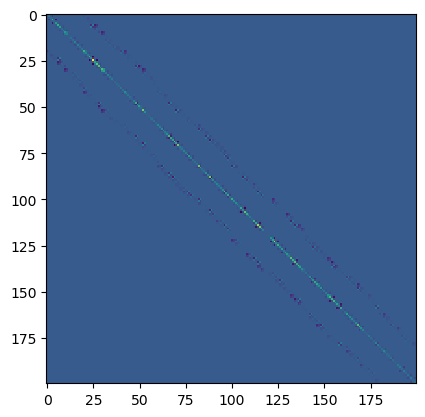

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/erouviere/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [6]:
imshow(H);

## Eigenvalue decomposition of the Hessian

In [7]:
# get eigenvalues and vectors, returned in increasing order.
evals = eigvals(H)
evecs = eigvecs(H)

200×200 Matrix{Float64}:
 -0.0519352    -0.141073    0.0410497  …  -3.2236e-5    -0.00168596
 -0.0287644     0.0611187  -0.126844      -2.91707e-5   -0.0017344
 -0.0415456    -0.132482    0.0269748      0.000173422   0.0109988
 -0.0290778     0.0608596  -0.12642        0.000162665   0.0110856
 -0.0262186    -0.119808    0.0062111     -5.86754e-5   -0.00470569
 -0.0282896     0.0615113  -0.127487   …   6.76516e-5    0.00109777
 -0.0112298    -0.107414   -0.0140945      0.0031177     0.30063
 -0.0294625     0.0605415  -0.125899      -0.00247049   -0.0978126
  0.000510476  -0.0977055  -0.0299992     -0.000283066  -0.00156327
 -0.0316415     0.0587397  -0.122947       0.00394092    0.0035605
  0.0137563    -0.0867524  -0.0479435  …  -0.081468      0.00548158
 -0.0303937     0.0597715  -0.124637      -0.0521665     0.00207805
  0.028471     -0.0745847  -0.0678777     -0.000458818   1.17178e-5
  ⋮                                    ⋱                
  0.00872098   -0.0909162  -0.0411221     

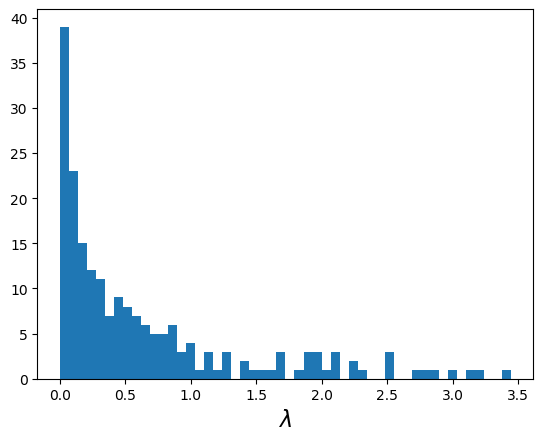

PyObject Text(0.5, 33.0, '$\\lambda$')

In [8]:
hist(evals, 50)
xlabel(L"\lambda", fontsize=16)

#### Translation and Rotations
Each eigenvalue represents the stiffness of the associated eigenvector or normal mode. Notice that there are 3 eigenvalues that are zero.

In [9]:
evals[1:10]

10-element Vector{Float64}:
 -2.5809782004452725e-16
 -9.863999123265105e-17
  1.97039434699316e-17
  0.004578656111874744
  0.005913053968021023
  0.00726937492341897
  0.008436522005937577
  0.009112134451221748
  0.01117317174663982
  0.01200712934697836

Let's see what these modes look like when drawn on a network. Here's a function for it.

In [10]:
function plotDisplacment!(ax, r, dr; zorder=1,
                         width=0.004, color="r", angles="xy", scale_units="xy", scale=0.5)
    xy = r2xy(r)
    x,y = xy[:,1], xy[:,2]
    uv = r2xy(dr)
    u,v = uv[:,1], uv[:,2]
    ax.quiver(x,y,u,v, zorder=zorder, width = width, color=color,
              scale=scale, angles=angles, scale_units=scale_units)
    return nothing
end

plotDisplacment! (generic function with 1 method)

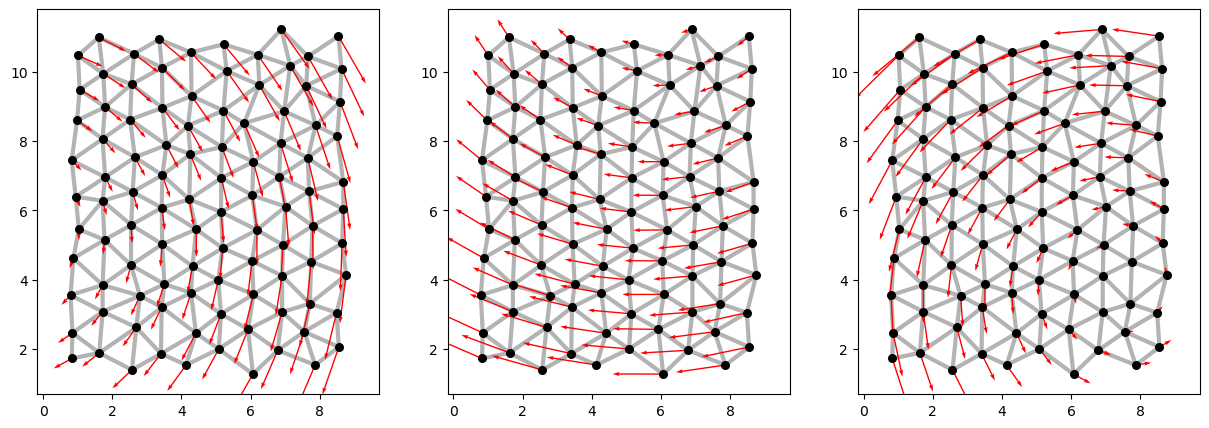

In [11]:
fig, ax = subplots(1,3, figsize=(15,5))

plotNetwork!(ax[1], r, A)
plotDisplacment!(ax[1], r, evecs[:,1], scale=0.1)

plotNetwork!(ax[2], r, A)
plotDisplacment!(ax[2], r, evecs[:,2], scale=0.1)

plotNetwork!(ax[3], r, A)
plotDisplacment!(ax[3], r, evecs[:,3], scale=0.1)

Together the three zeros modes span the same subspace as translation in x and y, and pure rotation. Notice that no part of these networks is being compressed and thus motions along these modes require no force.

Let's look as the three **softest** non zero modes

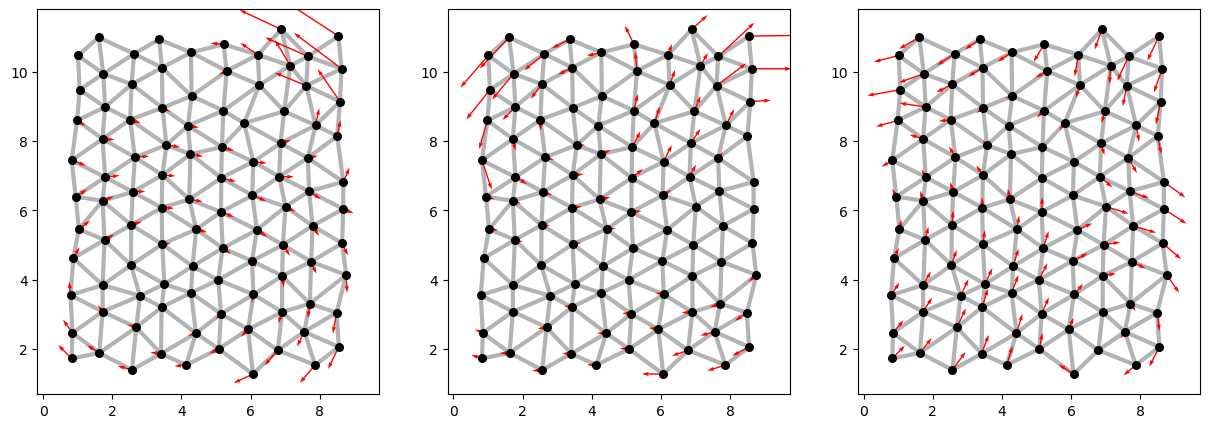

In [12]:
fig, ax = subplots(1,3, figsize=(15,5))
plotNetwork!(ax[1], r, A)
plotDisplacment!(ax[1], r, evecs[:,4], scale=0.2)

plotNetwork!(ax[2], r, A)
plotDisplacment!(ax[2], r, evecs[:,5], scale=0.2)

plotNetwork!(ax[3], r, A)
plotDisplacment!(ax[3], r, evecs[:,6], scale=0.2)

Let's look as the three **stiffest** non zero modes

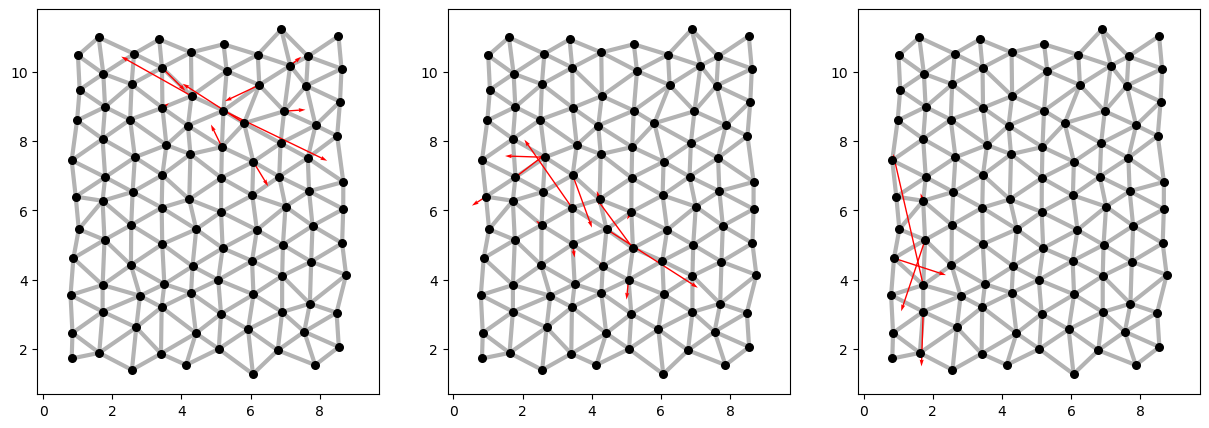

In [13]:
fig, ax = subplots(1,3, figsize=(15,5))
plotNetwork!(ax[1], r, A)
plotDisplacment!(ax[1], r, evecs[:,end-2], scale=0.2)

plotNetwork!(ax[2], r, A)
plotDisplacment!(ax[2], r, evecs[:,end-1], scale=0.2)

plotNetwork!(ax[3], r, A)
plotDisplacment!(ax[3], r, evecs[:,end], scale=0.2)

## Make a Network class (or struct in julia lingo)

In [14]:
struct Network
    seq::Vector{Int}
    r::Vector{Float64}
    S::Matrix{Float64}
    H::Matrix{Float64}
end

In [15]:
net = Network(seq, r, S, H)

Network([2, 5, 3, 1, 5, 1, 4, 3, 2, 3  …  3, 4, 2, 2, 4, 5, 2, 4, 3, 4], [0.8282190318327405, 1.716445478328653, 0.85055394193747, 2.456775180201698, 0.7943892621578438, 3.5489260907377416, 0.8779618833671006, 4.616980599427318, 1.0332293312376202, 5.453555345455819  …  8.683128949669637, 6.8228928655253345, 8.505425196622491, 8.15118009005558, 8.588073333647802, 9.145360593640426, 8.631431702683672, 10.096591378655011, 8.543988025468481, 11.03999695604054], [0.06973740410529515 0.36572845384474717 … 0.0 0.0; 0.36572845384474717 0.043367424114471004 … 0.0 0.0; … ; 0.0 0.0 … 0.019175508767689215 0.2179910594886244; 0.0 0.0 … 0.2179910594886244 0.554864176958728], [0.35153263821904657 0.0824544541427552 … 0.0 0.0; 0.0824544541427552 0.3799242694704477 … 0.0 0.0; … ; 0.0 0.0 … 0.1527375087555692 0.08059301444961098; 0.0 0.0 … 0.08059301444961098 0.2832446102216796])

In [18]:
net.seq

100-element Vector{Int64}:
 2
 5
 3
 1
 5
 1
 4
 3
 2
 3
 5
 1
 1
 ⋮
 3
 3
 3
 4
 2
 2
 4
 5
 2
 4
 3
 4

In [19]:
net.r

200-element Vector{Float64}:
  0.8282190318327405
  1.716445478328653
  0.85055394193747
  2.456775180201698
  0.7943892621578438
  3.5489260907377416
  0.8779618833671006
  4.616980599427318
  1.0332293312376202
  5.453555345455819
  0.9443153273512924
  6.397411047726568
  0.8273140999602949
  ⋮
  8.68160371311572
  6.0386089165043515
  8.683128949669637
  6.8228928655253345
  8.505425196622491
  8.15118009005558
  8.588073333647802
  9.145360593640426
  8.631431702683672
 10.096591378655011
  8.543988025468481
 11.03999695604054

In [20]:
net.S

100×100 Matrix{Float64}:
 0.0697374  0.365728   0.0        …  0.0        0.0        0.0
 0.365728   0.0433674  0.769562      0.0        0.0        0.0
 0.0        0.769562   0.0191755     0.0        0.0        0.0
 0.0        0.0        0.0909464     0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0        …  0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.365728   0.0433674  0.0        …  0.0        0.0        0.0
 0.0        0.223837   0.0909464     0.0        0.0        0.0
 0.0        0.0        0.0909464     0.0        0.0        0.0
 ⋮                                ⋱                        
 0.0        0.0        0.0           0.217991   0.0191755  0.0
 0.0        0.0        0.0       

In [21]:
function buildNetworkAndTable(W, L, q, disorder, k_min, k_max)
    r, A = buildStructure(W, L, disorder)
    seq = rand(1:q, W*L)
    K = buildSpringTable(q, k_min, k_max)
    S = seq2Springs(seq, K, A);
    H = computeHessian(r, S);
    net = Network(seq, r, S, H)
    return net, K
end

buildNetworkAndTable (generic function with 1 method)